In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval

In [13]:
STORE_PATH = '/home/pstefanou/knownVsUnknown'
STORE_TABLE_NAME = 'rebuttal'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/knownVsUnknown/d9486f1c-6a3d-49ca-a116-5d4c96932c72


In [ ]:
# regression parameters
num_samples, dims = 1000, 1
# noise_var = Tensor([9.0])
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
phi = Left(Tensor([1.0]))


# perform each experiment a total of 10 times
for iter_ in range(10):        
    for var in range(1, 10):
        # generate data
        X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(noise_var)).sample(ch.Size([num_samples]))
        # truncate
        # phi = Interval(Tensor([1.0]), Tensor([2.0]))
        indices = phi(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]


        # truncated linear regression with known noise variance
        reg = LinearRegression() 
        reg.fit(x_trunc, y_trunc)
        var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)

        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/num_samples]), 
            'phi': phi, 
            'epochs': 50,
            'num_workers': 2, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'lr': 1e-1,
            'unknown': False, 
            'var': var,
            'shuffle': True
        })


        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=args.unknown)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)

        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=num_samples, var=args.var)
        results = trunc_reg.fit(S)
        w_ = results.weight.detach()
        w0_ = results.bias.detach()

        # truncated linear regression with unknown noise variance
        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/num_samples]), 
            'phi': phi, 
            'epochs': 50,
            'num_workers': 2, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'var_lr': 1e-2,
            'lr': 1e-1,
            'unknown': True, 
            'shuffle': True
        })

        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=args.unknown)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)

        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=num_samples, var=args.var)

        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach().cpu()
        w = results.v.detach().cpu()*var_
        w0 = results.bias.detach().cpu()*var_
        
        # calculate metrics 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        unknown_params = ch.cat([w, w0])
        known_params = ch.cat([w_, w0_.unsqueeze(0)])
        unknown_param_mse = mean_squared_error(unknown_params, real_params)
        ols_param_mse = mean_squared_error(ols_params, real_params)
        known_param_mse = mean_squared_error(known_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'ols_param_mse': ols_param_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(noise_var), 
        })

# close current store
store.close()

Parameter containing:
tensor([3.4364], requires_grad=True)


Epoch:1 | Loss 2.0450 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.66it/s]
Epoch:2 | Loss 2.0453 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.25it/s]
Epoch:3 | Loss 2.0455 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.38it/s]
Epoch:4 | Loss 2.0455 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s]
Epoch:5 | Loss 2.0456 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]
Epoch:6 | Loss 2.0465 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.75it/s]
Epoch:7 | Loss 2.0457 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.39it/s]
Epoch:8 | Loss 2.0466 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 10.63it/s]
Epoch:9 | Loss 2.0472 | Train1 0.145 | Train5 -1

Epoch:19 | Loss 3.4489 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.62it/s]
Epoch:20 | Loss 3.2896 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]
Epoch:21 | Loss 3.7943 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]
Epoch:22 | Loss 3.8126 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.22it/s]
Epoch:23 | Loss 4.0124 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 14.20it/s]
Epoch:24 | Loss 4.4969 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 14.62it/s]
Epoch:25 | Loss 3.7652 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]
Epoch:26 | Loss 4.4521 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.55it/s]
Epoch:27 | Loss 4.5755 | Train1 0.141 | 

Parameter containing:
tensor([3.3165], requires_grad=True)


Epoch:1 | Loss 1.5745 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.56it/s]
Epoch:2 | Loss 1.5746 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.86it/s]
Epoch:3 | Loss 1.5748 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s]
Epoch:4 | Loss 1.5751 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.96it/s]
Epoch:5 | Loss 1.5757 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]
Epoch:6 | Loss 1.5754 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]
Epoch:7 | Loss 1.5755 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.78it/s]
Epoch:8 | Loss 1.5764 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]
Epoch:9 | Loss 1.5790 | Train1 0.134 | Train5 -1

Epoch:19 | Loss 1.8993 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.92it/s]
Epoch:20 | Loss 1.8668 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.85it/s]
Epoch:21 | Loss 1.8965 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]
Epoch:22 | Loss 1.9170 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]
Epoch:23 | Loss 1.9000 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.63it/s]
Epoch:24 | Loss 1.8648 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]
Epoch:25 | Loss 2.1117 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.87it/s]
Epoch:26 | Loss 1.9693 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.94it/s]
Epoch:27 | Loss 2.3885 | Train1 0.134 | 

Parameter containing:
tensor([3.4706], requires_grad=True)


Epoch:1 | Loss 1.6162 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.12it/s]
Epoch:2 | Loss 1.6166 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.67it/s]
Epoch:3 | Loss 1.6164 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.75it/s]
Epoch:4 | Loss 1.6168 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.12it/s]
Epoch:5 | Loss 1.6178 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.06it/s]
Epoch:6 | Loss 1.6182 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.58it/s]
Epoch:7 | Loss 1.6172 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.36it/s]
Epoch:8 | Loss 1.6188 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.23it/s]
Epoch:9 | Loss 1.6211 | Train1 0.113 | Train5 -1

Epoch:19 | Loss 1.9159 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.04it/s]
Epoch:20 | Loss 1.9665 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.80it/s]
Epoch:21 | Loss 3.1726 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.47it/s]
Epoch:22 | Loss 2.2359 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.24it/s]
Epoch:23 | Loss 1.9997 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.85it/s]
Epoch:24 | Loss 2.1375 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 56.42it/s]
Epoch:25 | Loss 1.9220 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.05it/s]
Epoch:26 | Loss 1.8967 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.00it/s]
Epoch:27 | Loss 2.2518 | Train1 0.113 | 

Parameter containing:
tensor([3.5159], requires_grad=True)


Epoch:1 | Loss 1.8097 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
Epoch:2 | Loss 1.8099 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.34it/s]
Epoch:3 | Loss 1.8102 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.91it/s]
Epoch:4 | Loss 1.8104 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.10it/s]
Epoch:5 | Loss 1.8103 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.30it/s]
Epoch:6 | Loss 1.8122 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.00it/s]
Epoch:7 | Loss 1.8107 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.90it/s]
Epoch:8 | Loss 1.8111 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.12it/s]
Epoch:9 | Loss 1.8128 | Train1 0.121 | Train5 -1

Epoch:19 | Loss 2.1924 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.79it/s]
Epoch:20 | Loss 2.5026 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.85it/s]
Epoch:21 | Loss 2.9269 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.53it/s]
Epoch:22 | Loss 2.5330 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.00it/s]
Epoch:23 | Loss 2.6344 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.79it/s]
Epoch:24 | Loss 2.6350 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.31it/s]
Epoch:25 | Loss 2.9562 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.28it/s]
Epoch:26 | Loss 2.7863 | Train1 0.121 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.28it/s]
Epoch:27 | Loss 2.7377 | Train1 0.121 | 

Parameter containing:
tensor([3.4888], requires_grad=True)


Epoch:1 | Loss 1.8001 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.70it/s]
Epoch:2 | Loss 1.8002 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]
Epoch:3 | Loss 1.8010 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]
Epoch:4 | Loss 1.8012 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s]
Epoch:5 | Loss 1.8007 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
Epoch:6 | Loss 1.8018 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.77it/s]
Epoch:7 | Loss 1.8014 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s]
Epoch:8 | Loss 1.8012 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.95it/s]
Epoch:9 | Loss 1.8025 | Train1 0.099 | Train5 -1

Epoch:19 | Loss 2.3667 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.17it/s]
Epoch:20 | Loss 2.4308 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.69it/s]
Epoch:21 | Loss 2.3374 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.96it/s]
Epoch:22 | Loss 2.3165 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.06it/s]
Epoch:23 | Loss 2.4205 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.19it/s]
Epoch:24 | Loss 2.4503 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.20it/s]
Epoch:25 | Loss 2.4692 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.16it/s]
Epoch:26 | Loss 2.2641 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.77it/s]
Epoch:27 | Loss 2.6641 | Train1 0.099 | 

Parameter containing:
tensor([3.3741], requires_grad=True)


Epoch:1 | Loss 1.7134 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s]
Epoch:2 | Loss 1.7136 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.59it/s]
Epoch:3 | Loss 1.7136 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.77it/s]
Epoch:4 | Loss 1.7137 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.66it/s]
Epoch:5 | Loss 1.7145 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s]
Epoch:6 | Loss 1.7149 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.89it/s]
Epoch:7 | Loss 1.7154 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.91it/s]
Epoch:8 | Loss 1.7155 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.68it/s]
Epoch:9 | Loss 1.7158 | Train1 0.127 | Train5 -1

Epoch:19 | Loss 2.2630 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.47it/s]
Epoch:20 | Loss 2.1515 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.73it/s]
Epoch:21 | Loss 2.3031 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.49it/s]
Epoch:22 | Loss 2.3452 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.30it/s]
Epoch:23 | Loss 2.2415 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]
Epoch:24 | Loss 2.4590 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.32it/s]
Epoch:25 | Loss 2.4518 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.50it/s]
Epoch:26 | Loss 2.5792 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.71it/s]
Epoch:27 | Loss 2.5464 | Train1 0.125 | 

Parameter containing:
tensor([3.6161], requires_grad=True)


Epoch:1 | Loss 1.8306 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.81it/s]
Epoch:2 | Loss 1.8309 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.22it/s]
Epoch:3 | Loss 1.8312 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.77it/s]
Epoch:4 | Loss 1.8312 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.24it/s]
Epoch:5 | Loss 1.8311 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.08it/s]
Epoch:6 | Loss 1.8313 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]
Epoch:7 | Loss 1.8318 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.39it/s]
Epoch:8 | Loss 1.8316 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s]
Epoch:9 | Loss 1.8316 | Train1 0.100 | Train5 -1

Epoch:19 | Loss 2.1199 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]
Epoch:20 | Loss 2.0210 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.91it/s]
Epoch:21 | Loss 2.2671 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.31it/s]
Epoch:22 | Loss 2.2376 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.69it/s]
Epoch:23 | Loss 2.1779 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s]
Epoch:24 | Loss 2.1512 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.11it/s]
Epoch:25 | Loss 2.2053 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]
Epoch:26 | Loss 2.3471 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]
Epoch:27 | Loss 2.1102 | Train1 0.100 | 

Parameter containing:
tensor([3.4933], requires_grad=True)


Epoch:1 | Loss 1.7371 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.89it/s]
Epoch:2 | Loss 1.7372 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.60it/s]
Epoch:3 | Loss 1.7372 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]
Epoch:4 | Loss 1.7380 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.82it/s]
Epoch:5 | Loss 1.7383 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.29it/s]
Epoch:6 | Loss 1.7375 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.41it/s]
Epoch:7 | Loss 1.7379 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.50it/s]
Epoch:8 | Loss 1.7382 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.62it/s]
Epoch:9 | Loss 1.7422 | Train1 0.146 | Train5 -1

Epoch:19 | Loss 2.1433 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.51it/s]
Epoch:20 | Loss 2.3852 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.43it/s]
Epoch:21 | Loss 2.6415 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.76it/s]
Epoch:22 | Loss 2.4213 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.99it/s]
Epoch:23 | Loss 2.4718 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.50it/s]
Epoch:24 | Loss 3.4899 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.59it/s]
Epoch:25 | Loss 3.1818 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.11it/s]
Epoch:26 | Loss 2.7854 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.14it/s]
Epoch:27 | Loss 2.5804 | Train1 0.146 | 

Parameter containing:
tensor([3.4566], requires_grad=True)


Epoch:1 | Loss 2.0402 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.57it/s]
Epoch:2 | Loss 2.0404 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.11it/s]
Epoch:3 | Loss 2.0405 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.46it/s]
Epoch:4 | Loss 2.0425 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.48it/s]
Epoch:5 | Loss 2.0427 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.04it/s]
Epoch:6 | Loss 2.0403 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.42it/s]
Epoch:7 | Loss 2.0424 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.51it/s]
Epoch:8 | Loss 2.0415 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.45it/s]
Epoch:9 | Loss 2.0430 | Train1 0.148 | Train5 -1

Epoch:19 | Loss 4.2200 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.78it/s]
Epoch:20 | Loss 2.9472 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.12it/s]
Epoch:21 | Loss 3.4556 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 42.38it/s]
Epoch:22 | Loss 4.2260 | Train1 0.146 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.73it/s]
Epoch:23 | Loss 3.5043 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.01it/s]
Epoch:24 | Loss 3.5838 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.14it/s]
Epoch:25 | Loss 4.9406 | Train1 0.148 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.76it/s]
Epoch:26 | Loss 4.5591 | Train1 0.142 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.74it/s]
Epoch:27 | Loss 4.1770 | Train1 0.142 | 

Parameter containing:
tensor([3.3516], requires_grad=True)



Epoch:1 | Loss 1.7085 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.65it/s]
Epoch:2 | Loss 1.7087 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.94it/s]
Epoch:3 | Loss 1.7089 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.17it/s]
Epoch:4 | Loss 1.7095 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.70it/s]
Epoch:5 | Loss 1.7088 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.52it/s]
Epoch:6 | Loss 1.7095 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.58it/s]
Epoch:7 | Loss 1.7103 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.65it/s]
Epoch:8 | Loss 1.7108 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.05it/s]
Epoch:9 | Loss 1.7116 | Train1 0.140 | Train5 -

Epoch:19 | Loss 2.3601 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.42it/s]
Epoch:20 | Loss 2.5039 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.23it/s]
Epoch:21 | Loss 2.6359 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.79it/s]
Epoch:22 | Loss 2.8126 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.67it/s]
Epoch:23 | Loss 2.9432 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.95it/s]
Epoch:24 | Loss 3.0492 | Train1 0.131 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.95it/s]
Epoch:25 | Loss 2.8545 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.04it/s]
Epoch:26 | Loss 2.8349 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.32it/s]
Epoch:27 | Loss 3.0207 | Train1 0.140 | 

Parameter containing:
tensor([3.4081], requires_grad=True)


Epoch:1 | Loss 1.7327 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.38it/s]
Epoch:2 | Loss 1.7330 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.66it/s]
Epoch:3 | Loss 1.7332 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.52it/s]
Epoch:4 | Loss 1.7331 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.87it/s]
Epoch:5 | Loss 1.7333 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.87it/s]
Epoch:6 | Loss 1.7353 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.33it/s]
Epoch:7 | Loss 1.7345 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.30it/s]
Epoch:8 | Loss 1.7332 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.58it/s]
Epoch:9 | Loss 1.7352 | Train1 0.115 | Train5 -1

Epoch:19 | Loss 2.4949 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 57.36it/s]
Epoch:20 | Loss 2.3852 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.95it/s]
Epoch:21 | Loss 2.5252 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 43.51it/s]
Epoch:22 | Loss 2.5444 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.83it/s]
Epoch:23 | Loss 2.6340 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.45it/s]
Epoch:24 | Loss 2.7060 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.12it/s]
Epoch:25 | Loss 2.8311 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.19it/s]
Epoch:26 | Loss 2.8626 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.43it/s]
Epoch:27 | Loss 3.3062 | Train1 0.115 | 

Parameter containing:
tensor([3.3947], requires_grad=True)


Epoch:1 | Loss 1.7344 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.94it/s]
Epoch:2 | Loss 1.7347 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.93it/s]
Epoch:3 | Loss 1.7353 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.52it/s]
Epoch:4 | Loss 1.7348 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s]
Epoch:5 | Loss 1.7349 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.44it/s]
Epoch:6 | Loss 1.7358 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.90it/s]
Epoch:7 | Loss 1.7354 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]
Epoch:8 | Loss 1.7365 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.35it/s]
Epoch:9 | Loss 1.7357 | Train1 0.133 | Train5 -1

Epoch:19 | Loss 2.2410 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.13it/s]
Epoch:20 | Loss 2.2823 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.99it/s]
Epoch:21 | Loss 2.4567 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]
Epoch:22 | Loss 2.5184 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.94it/s]
Epoch:23 | Loss 2.4038 | Train1 0.131 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.50it/s]
Epoch:24 | Loss 3.0083 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.81it/s]
Epoch:25 | Loss 2.5747 | Train1 0.129 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]
Epoch:26 | Loss 2.8301 | Train1 0.129 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.78it/s]
Epoch:27 | Loss 2.7825 | Train1 0.131 | 

Parameter containing:
tensor([3.3978], requires_grad=True)


Epoch:1 | Loss 1.6924 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.45it/s]
Epoch:2 | Loss 1.6925 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.14it/s]
Epoch:3 | Loss 1.6925 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.72it/s]
Epoch:4 | Loss 1.6926 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.21it/s]
Epoch:5 | Loss 1.6932 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.68it/s]
Epoch:6 | Loss 1.6943 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.73it/s]
Epoch:7 | Loss 1.6967 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.62it/s]
Epoch:8 | Loss 1.6956 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.46it/s]
Epoch:9 | Loss 1.6948 | Train1 0.141 | Train5 -1

Epoch:19 | Loss 2.3431 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.30it/s]
Epoch:20 | Loss 2.3513 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.62it/s]
Epoch:21 | Loss 2.2638 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.10it/s]
Epoch:22 | Loss 2.6248 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.10it/s]
Epoch:23 | Loss 2.7811 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.36it/s]
Epoch:24 | Loss 2.7334 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s]
Epoch:25 | Loss 2.9105 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.18it/s]
Epoch:26 | Loss 2.6392 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 14.62it/s]
Epoch:27 | Loss 2.4282 | Train1 0.141 | 

Parameter containing:
tensor([3.4680], requires_grad=True)


Epoch:1 | Loss 1.7990 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.23it/s]
Epoch:2 | Loss 1.7992 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.91it/s]
Epoch:3 | Loss 1.7993 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.95it/s]
Epoch:4 | Loss 1.7992 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s]
Epoch:5 | Loss 1.8004 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s]
Epoch:6 | Loss 1.8011 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.76it/s]
Epoch:7 | Loss 1.7995 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s]
Epoch:8 | Loss 1.8003 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.34it/s]
Epoch:9 | Loss 1.8023 | Train1 0.128 | Train5 -1

Epoch:19 | Loss 2.3646 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.16it/s]
Epoch:20 | Loss 2.4365 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.83it/s]
Epoch:21 | Loss 2.5730 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]
Epoch:22 | Loss 2.4374 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.90it/s]
Epoch:23 | Loss 3.1226 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.52it/s]
Epoch:24 | Loss 2.7040 | Train1 0.124 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.68it/s]
Epoch:25 | Loss 2.8586 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.11it/s]
Epoch:26 | Loss 2.7041 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.41it/s]
Epoch:27 | Loss 3.2324 | Train1 0.128 | 

Parameter containing:
tensor([3.5285], requires_grad=True)


Epoch:1 | Loss 1.8768 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.38it/s]
Epoch:2 | Loss 1.8770 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.65it/s]
Epoch:3 | Loss 1.8774 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.80it/s]
Epoch:4 | Loss 1.8778 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s]
Epoch:5 | Loss 1.8782 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s]
Epoch:6 | Loss 1.8784 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.50it/s]
Epoch:7 | Loss 1.8780 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s]
Epoch:8 | Loss 1.8776 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.46it/s]
Epoch:9 | Loss 1.8786 | Train1 0.104 | Train5 -1

Epoch:19 | Loss 2.2052 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.37it/s]
Epoch:20 | Loss 2.6304 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.53it/s]
Epoch:21 | Loss 2.3595 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]
Epoch:22 | Loss 2.3331 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.95it/s]
Epoch:23 | Loss 2.3208 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.00it/s]
Epoch:24 | Loss 2.8043 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.73it/s]
Epoch:25 | Loss 2.6097 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.53it/s]
Epoch:26 | Loss 2.9290 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.35it/s]
Epoch:27 | Loss 2.4719 | Train1 0.104 | 

Parameter containing:
tensor([3.4272], requires_grad=True)


Epoch:1 | Loss 1.8607 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.78it/s]
Epoch:2 | Loss 1.8609 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s]
Epoch:3 | Loss 1.8611 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.92it/s]
Epoch:4 | Loss 1.8612 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]
Epoch:5 | Loss 1.8615 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.32it/s]
Epoch:6 | Loss 1.8620 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s]
Epoch:7 | Loss 1.8616 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.77it/s]
Epoch:8 | Loss 1.8622 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.33it/s]
Epoch:9 | Loss 1.8625 | Train1 0.128 | Train5 -1

Epoch:19 | Loss 2.5109 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.66it/s]
Epoch:20 | Loss 2.5474 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.47it/s]
Epoch:21 | Loss 2.3702 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.93it/s]
Epoch:22 | Loss 2.7105 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.37it/s]
Epoch:23 | Loss 2.7395 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]
Epoch:24 | Loss 3.0129 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.28it/s]
Epoch:25 | Loss 3.0351 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.96it/s]
Epoch:26 | Loss 3.2712 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.55it/s]
Epoch:27 | Loss 3.2264 | Train1 0.128 | 

Parameter containing:
tensor([3.2969], requires_grad=True)



Epoch:1 | Loss 1.7210 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.13it/s]
Epoch:2 | Loss 1.7211 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.76it/s]
Epoch:3 | Loss 1.7211 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.60it/s]
Epoch:4 | Loss 1.7223 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.48it/s]
Epoch:5 | Loss 1.7230 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.11it/s]
Epoch:6 | Loss 1.7229 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.87it/s]
Epoch:7 | Loss 1.7219 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.96it/s]
Epoch:8 | Loss 1.7233 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.51it/s]
Epoch:9 | Loss 1.7233 | Train1 0.135 | Train5 -

Epoch:19 | Loss 2.5535 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.07it/s]
Epoch:20 | Loss 2.2712 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 55.56it/s]
Epoch:21 | Loss 3.1612 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.75it/s]
Epoch:22 | Loss 2.5469 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.61it/s]
Epoch:23 | Loss 3.0953 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.81it/s]
Epoch:24 | Loss 2.7982 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.59it/s]
Epoch:25 | Loss 2.8936 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.23it/s]
Epoch:26 | Loss 2.9823 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.73it/s]
Epoch:27 | Loss 2.7358 | Train1 0.124 | 

Parameter containing:
tensor([3.3792], requires_grad=True)


Epoch:1 | Loss 1.6587 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
Epoch:2 | Loss 1.6590 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.51it/s]
Epoch:3 | Loss 1.6590 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.54it/s]
Epoch:4 | Loss 1.6602 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.64it/s]
Epoch:5 | Loss 1.6594 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.28it/s]
Epoch:6 | Loss 1.6598 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.28it/s]
Epoch:7 | Loss 1.6601 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.53it/s]
Epoch:8 | Loss 1.6609 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.72it/s]
Epoch:9 | Loss 1.6629 | Train1 0.122 | Train5 -1

Epoch:19 | Loss 2.1954 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 45.98it/s]
Epoch:20 | Loss 2.1040 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.98it/s]
Epoch:21 | Loss 2.3434 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.59it/s]
Epoch:22 | Loss 2.4471 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.75it/s]
Epoch:23 | Loss 2.1019 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.25it/s]
Epoch:24 | Loss 2.3819 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.33it/s]
Epoch:25 | Loss 2.0813 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.87it/s]
Epoch:26 | Loss 2.3452 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.11it/s]
Epoch:27 | Loss 2.1248 | Train1 0.122 | 

Parameter containing:
tensor([3.6167], requires_grad=True)


Epoch:1 | Loss 1.7837 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.85it/s]
Epoch:2 | Loss 1.7838 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.67it/s]
Epoch:3 | Loss 1.7843 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.23it/s]
Epoch:4 | Loss 1.7850 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s]
Epoch:5 | Loss 1.7853 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.00it/s]
Epoch:6 | Loss 1.7864 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]
Epoch:7 | Loss 1.7847 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.43it/s]
Epoch:8 | Loss 1.7846 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.27it/s]
Epoch:9 | Loss 1.7868 | Train1 0.116 | Train5 -1

Epoch:19 | Loss 2.2327 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.34it/s]
Epoch:20 | Loss 2.2833 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.11it/s]
Epoch:21 | Loss 2.2823 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.52it/s]
Epoch:22 | Loss 2.1290 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.55it/s]
Epoch:23 | Loss 2.1692 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.43it/s]
Epoch:24 | Loss 2.2702 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 41.35it/s]
Epoch:25 | Loss 2.2033 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.11it/s]
Epoch:26 | Loss 2.0410 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.96it/s]
Epoch:27 | Loss 2.1598 | Train1 0.116 | 

Parameter containing:
tensor([3.4077], requires_grad=True)


Epoch:1 | Loss 1.7672 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.06it/s]
Epoch:2 | Loss 1.7679 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.76it/s]
Epoch:3 | Loss 1.7674 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.89it/s]
Epoch:4 | Loss 1.7679 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.00it/s]
Epoch:5 | Loss 1.7687 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.74it/s]
Epoch:6 | Loss 1.7688 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.11it/s]
Epoch:7 | Loss 1.7685 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.47it/s]
Epoch:8 | Loss 1.7696 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.20it/s]
Epoch:9 | Loss 1.7703 | Train1 0.125 | Train5 -1

Epoch:19 | Loss 2.9965 | Train1 0.123 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.85it/s]
Epoch:20 | Loss 2.5527 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.42it/s]
Epoch:21 | Loss 2.4125 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.90it/s]
Epoch:22 | Loss 2.5635 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.88it/s]
Epoch:23 | Loss 3.0613 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.60it/s]
Epoch:24 | Loss 2.3764 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.47it/s]
Epoch:25 | Loss 2.6499 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.34it/s]
Epoch:26 | Loss 3.0838 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.17it/s]
Epoch:27 | Loss 2.9942 | Train1 0.125 | 

Parameter containing:
tensor([3.4228], requires_grad=True)


Epoch:1 | Loss 1.5458 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s]
Epoch:2 | Loss 1.5460 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.69it/s]
Epoch:3 | Loss 1.5466 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.11it/s]
Epoch:4 | Loss 1.5461 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.13it/s]
Epoch:5 | Loss 1.5464 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s]
Epoch:6 | Loss 1.5463 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.23it/s]
Epoch:7 | Loss 1.5472 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.05it/s]
Epoch:8 | Loss 1.5472 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
Epoch:9 | Loss 1.5479 | Train1 0.090 | Train5 -1

Epoch:19 | Loss 1.7151 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 49.72it/s]
Epoch:20 | Loss 1.8025 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.39it/s]
Epoch:21 | Loss 1.6648 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 47.18it/s]
Epoch:22 | Loss 1.7830 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.19it/s]
Epoch:23 | Loss 1.8278 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.71it/s]
Epoch:24 | Loss 1.8378 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.77it/s]
Epoch:25 | Loss 1.8443 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.62it/s]
Epoch:26 | Loss 1.9258 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 42.71it/s]
Epoch:27 | Loss 1.9254 | Train1 0.090 | 

Parameter containing:
tensor([3.4500], requires_grad=True)


Epoch:1 | Loss 1.6035 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.39it/s]
Epoch:2 | Loss 1.6037 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.10it/s]
Epoch:3 | Loss 1.6039 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.86it/s]
Epoch:4 | Loss 1.6042 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.88it/s]
Epoch:5 | Loss 1.6037 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.80it/s]
Epoch:6 | Loss 1.6041 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.43it/s]
Epoch:7 | Loss 1.6043 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.02it/s]
Epoch:8 | Loss 1.6043 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.10it/s]
Epoch:9 | Loss 1.6054 | Train1 0.120 | Train5 -1

Epoch:19 | Loss 1.8777 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.28it/s]
Epoch:20 | Loss 1.8956 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 43.03it/s]
Epoch:21 | Loss 2.0134 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 48.91it/s]
Epoch:22 | Loss 1.9672 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 44.89it/s]
Epoch:23 | Loss 1.8764 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.21it/s]
Epoch:24 | Loss 2.0148 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.23it/s]
Epoch:25 | Loss 2.0880 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 46.71it/s]
Epoch:26 | Loss 1.9450 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 45.28it/s]
Epoch:27 | Loss 2.0074 | Train1 0.120 | 

Parameter containing:
tensor([3.2804], requires_grad=True)


Epoch:1 | Loss 1.5559 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.15it/s]
Epoch:2 | Loss 1.5560 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.50it/s]
Epoch:3 | Loss 1.5562 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.35it/s]
Epoch:4 | Loss 1.5562 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.56it/s]
Epoch:5 | Loss 1.5575 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.62it/s]
Epoch:6 | Loss 1.5573 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.56it/s]
Epoch:7 | Loss 1.5577 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.32it/s]
Epoch:8 | Loss 1.5578 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.28it/s]
Epoch:9 | Loss 1.5581 | Train1 0.143 | Train5 -1

Epoch:19 | Loss 1.9315 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.75it/s]
Epoch:20 | Loss 2.1685 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.22it/s]
Epoch:21 | Loss 2.0879 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.47it/s]
Epoch:22 | Loss 1.8925 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.07it/s]
Epoch:23 | Loss 2.1750 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.40it/s]
Epoch:24 | Loss 2.8408 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.47it/s]
Epoch:25 | Loss 2.5581 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.41it/s]
Epoch:26 | Loss 2.6481 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.43it/s]
Epoch:27 | Loss 2.3044 | Train1 0.139 | 

Parameter containing:
tensor([3.4651], requires_grad=True)


Epoch:1 | Loss 1.7219 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.49it/s]
Epoch:2 | Loss 1.7222 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.29it/s]
Epoch:3 | Loss 1.7223 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.72it/s]
Epoch:4 | Loss 1.7224 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.87it/s]
Epoch:5 | Loss 1.7228 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.63it/s]
Epoch:6 | Loss 1.7226 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.49it/s]
Epoch:7 | Loss 1.7234 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.91it/s]
Epoch:8 | Loss 1.7240 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.82it/s]
Epoch:9 | Loss 1.7274 | Train1 0.109 | Train5 -1

Epoch:19 | Loss 2.1848 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 45.74it/s]
Epoch:20 | Loss 1.9832 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.75it/s]
Epoch:21 | Loss 2.0772 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.74it/s]
Epoch:22 | Loss 2.2913 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 47.40it/s]
Epoch:23 | Loss 2.4455 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.60it/s]
Epoch:24 | Loss 2.3073 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 46.64it/s]
Epoch:25 | Loss 2.0747 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.84it/s]
Epoch:26 | Loss 2.4295 | Train1 0.107 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.79it/s]
Epoch:27 | Loss 2.6559 | Train1 0.105 | 

Parameter containing:
tensor([3.5147], requires_grad=True)


Epoch:1 | Loss 1.7683 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s]
Epoch:2 | Loss 1.7684 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00,  8.49it/s]
Epoch:3 | Loss 1.7687 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s]
Epoch:4 | Loss 1.7686 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.73it/s]
Epoch:5 | Loss 1.7686 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.50it/s]
Epoch:6 | Loss 1.7698 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 16.81it/s]
Epoch:7 | Loss 1.7699 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.81it/s]
Epoch:8 | Loss 1.7703 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 17.25it/s]
Epoch:9 | Loss 1.7710 | Train1 0.127 | Train5 -1

Epoch:19 | Loss 2.0568 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.78it/s]
Epoch:20 | Loss 2.2339 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s]
Epoch:21 | Loss 2.1408 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.51it/s]
Epoch:22 | Loss 2.0485 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.19it/s]
Epoch:23 | Loss 2.0406 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 15.17it/s]
Epoch:24 | Loss 2.2764 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.70it/s]
Epoch:25 | Loss 2.2085 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]
Epoch:26 | Loss 2.3612 | Train1 0.127 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 5/5 [00:00<00:00, 13.22it/s]
Epoch:27 | Loss 2.3426 | Train1 0.127 | 

Parameter containing:
tensor([3.5203], requires_grad=True)


Epoch:1 | Loss 1.9121 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.89it/s]
Epoch:2 | Loss 1.9122 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.73it/s]
Epoch:3 | Loss 1.9125 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.30it/s]
Epoch:4 | Loss 1.9131 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.71it/s]
Epoch:5 | Loss 1.9128 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.10it/s]
Epoch:6 | Loss 1.9136 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.24it/s]
Epoch:7 | Loss 1.9148 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.60it/s]
Epoch:8 | Loss 1.9146 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 16.84it/s]
Epoch:9 | Loss 1.9140 | Train1 0.141 | Train5 -1

Epoch:19 | Loss 2.7331 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 54.88it/s]
Epoch:20 | Loss 2.6585 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.90it/s]
Epoch:21 | Loss 2.8152 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.99it/s]
Epoch:22 | Loss 2.8362 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.14it/s]
Epoch:23 | Loss 3.4134 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.37it/s]
Epoch:24 | Loss 2.8781 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.39it/s]
Epoch:25 | Loss 3.0822 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.89it/s]
Epoch:26 | Loss 3.0685 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.04it/s]
Epoch:27 | Loss 3.1814 | Train1 0.141 | 

Parameter containing:
tensor([3.3647], requires_grad=True)


Epoch:1 | Loss 1.5556 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.06it/s]
Epoch:2 | Loss 1.5558 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 15.48it/s]
Epoch:3 | Loss 1.5561 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.41it/s]
Epoch:4 | Loss 1.5562 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.39it/s]
Epoch:5 | Loss 1.5570 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 10.93it/s]
Epoch:6 | Loss 1.5566 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.47it/s]
Epoch:7 | Loss 1.5569 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.24it/s]
Epoch:8 | Loss 1.5573 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00,  9.99it/s]
Epoch:9 | Loss 1.5647 | Train1 0.122 | Train5 -1

Epoch:19 | Loss 2.0023 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 48.87it/s]
Epoch:20 | Loss 4.2469 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.72it/s]
Epoch:21 | Loss 2.3019 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 49.19it/s]
Epoch:22 | Loss 2.2092 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 53.55it/s]
Epoch:23 | Loss 1.9220 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.94it/s]
Epoch:24 | Loss 2.1042 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 52.34it/s]
Epoch:25 | Loss 2.3096 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 50.73it/s]
Epoch:26 | Loss 2.7902 | Train1 0.120 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 51.44it/s]
Epoch:27 | Loss 2.0514 | Train1 0.120 | 

Parameter containing:
tensor([3.5025], requires_grad=True)


Epoch:1 | Loss 1.6956 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 18.12it/s]
Epoch:2 | Loss 1.6958 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.53it/s]
Epoch:3 | Loss 1.6961 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.08it/s]
Epoch:4 | Loss 1.6965 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.23it/s]
Epoch:5 | Loss 1.6968 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.43it/s]
Epoch:6 | Loss 1.6968 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.13it/s]
Epoch:7 | Loss 1.6970 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.45it/s]
Epoch:8 | Loss 1.6975 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 6/6 [00:00<00:00, 17.27it/s]
Epoch:9 | Loss 1.6983 | Train1 0.108 | Train5 -1

Text(0, 0.5, 'y')

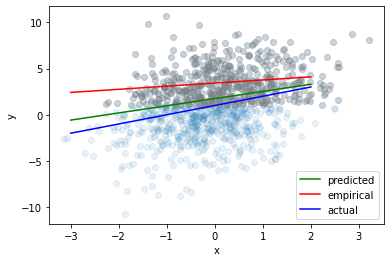

In [20]:
points = np.linspace(-3.0, 2.0, 1000)

plt.scatter(X, y, alpha=.1)
plt.scatter(x_trunc, y_trunc, color="grey", alpha=.25)

with ch.no_grad():
    plt.plot(points, results(ch.from_numpy(np.expand_dims(points, 1)).float()), color="green", label="predicted")
    plt.plot(points, S.dataset.reg.predict(np.expand_dims(points, 1)), color="red", label="empirical")
    plt.plot(points, ch.from_numpy(np.expand_dims(points, 1)).float().mm(W) + W0, color="blue", label="actual")
plt.legend() 

plt.xlabel("x")
plt.ylabel("y")

In [22]:
data.var

tensor([[3.4674]])

In [4]:
results.weight

Parameter containing:
tensor([[0.2535]], requires_grad=True)

In [5]:
results.bias

Parameter containing:
tensor([3.4549], requires_grad=True)

Text(0, 0.5, 'y')

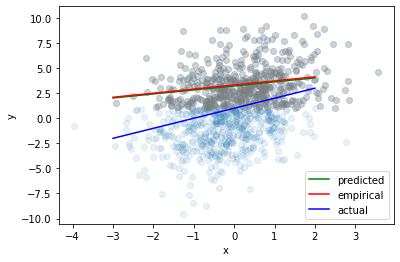

In [10]:
points = np.linspace(-3.0, 2.0, 1000)

plt.scatter(X, y, alpha=.1)
plt.scatter(x_trunc, y_trunc, color="grey", alpha=.25)

with ch.no_grad():
    plt.plot(points, results(ch.from_numpy(np.expand_dims(points, 1)).float()), color="green", label="predicted")
    plt.plot(points, S.dataset.reg.predict(np.expand_dims(points, 1)), color="red", label="empirical")
    plt.plot(points, ch.from_numpy(np.expand_dims(points, 1)).float().mm(W) + W0, color="blue", label="actual")
plt.legend() 

plt.xlabel("x")
plt.ylabel("y")

In [25]:
mean_squared_error(real_params, ch.cat([w_, w0_.unsqueeze(0)]).detach())

3.006596